### Notebook to prepare spectogram data for input to a CNN

#### Test data is a data set consisting of 89 VAG signals
#### 51 normal and 38 pathological

In [118]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, lfilter
from scipy.signal import stft, spectrogram, get_window
from scipy.signal.windows import hann
import os
import matplotlib.pyplot as plt

#### Read the data
data is simply a list of magnitdue accleration values in each file

In [119]:
healthy_dir = "../../data/open_vag/normal/"
pathology_dir = "../../data/open_vag/pathology/"
#healthy_base = "novag"
#pathology_base  = "abvag"

healthy_subs = [] # 51
pathology_subs = [] # 38

exclude = {".ipynb_checkpoints"}

healthy_files = [f for f in os.listdir(healthy_dir) if '.ipynb_checkpoints' not in f]
print(f" healthy vag signals {len(healthy_files)}")
pathology_files = [f for f in os.listdir(pathology_dir) if '.ipynb_checkpoints' not in f]
print(f" pathology vag signals {len(pathology_files)}")

max_size_files = max(len(healthy_files), len(pathology_files))

for i in range(0, max_size_files):
    if(i < len(healthy_files)):
        # read in a healthy_file
        file_path = os.path.join(healthy_dir, healthy_files[i])
        with open(file_path, 'r') as file:
            # Read all the floating-point numbers into a list
            vags = [float(x) for x in file.read().split()]
            healthy_subs.append(vags)
    if(i < len(pathology_files)):
        file_path = os.path.join(pathology_dir, pathology_files[i])
        with open(file_path, 'r') as file:
            # Read all the floating-point numbers into a list
            vags = [float(x) for x in file.read().split()]
            pathology_subs.append(vags)   

 healthy vag signals 51
 pathology vag signals 38


#### amplitude normalise and resample to 8192 samples long


In [153]:
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

def resample_vag_signal(d_set, n_points, fs, b,a, do_filter):
    n = amplitude_normal(d_set)
    t = np.linspace(0, fs, num=len(n))  # Original x values (e.g., time or sample indices)
    x_new = np.linspace(t.min(), t.max(), n_points)
    
    # Create an interpolation function
    interpolator = interp1d(t, n, kind='linear')
    y_new = interpolator(x_new)

    # filter the signal
    if(do_filter):
        y_filtered = filter_signal(b,a, y_new, "filtfilt")
    else:
        y_filtered  = y_new 
    return y_filtered


# build a filter 
low_cut_off = 100 # removes muscle artifacts and baseline wander
high_cut_off = 1000
filter_order = 5   # 9th order has been used in literature?
filter_type =  "bandpass"  #"bandpass", high, low
n_l = 8192  # next fft points value int(math.pow(2, math.ceil(math.log2(len(data)))))
fs = 2001 # sampling_frequency 2kH

b,a = build_filter((low_cut_off, high_cut_off), fs, filter_type, filter_order)

healthy_resampled = []
pathology_resampled = []

do_filter = False
for d_set in healthy_subs:
    r = resample_vag_signal(d_set, n_l, fs, b,a, do_filter)
    healthy_resampled.append(r)

for d_set in pathology_subs:
    r = resample_vag_signal(d_set, n_l, fs, b,a, do_filter)
    pathology_resampled.append(r)

#### Compute the STFT 

In [154]:
segment_length = 256  # Number of samples per segment
overlap = 50  # Overlap of 100 samples
window = hann(segment_length)

stft_healthy = []
stft_pathology = []

def compute_power(Zxx):
    pwr = np.abs(Zxx)**2
    p_Zxx = 10 * np.log10(np.abs(Zxx)+ 1e-20) # add small value to avoid divide by zero
    return p_Zxx

def compute_stft(signal, fs, window, seg_len, overlap):
    f, t, Zxx = stft(signal, fs=fs, window=window,  nperseg=seg_len, noverlap=overlap)

    p_Zxx = compute_power(Zxx)
    #print(p_Zxx)
    return [f,t,p_Zxx]

for i, vag in enumerate(healthy_resampled):
    s = compute_stft(vag, fs, window, segment_length, overlap)
    stft_healthy.append(s)

for i, vag in enumerate(pathology_resampled):
    s = compute_stft(vag, fs, window, segment_length, overlap)
    stft_pathology.append(s)


#### Save the data to 2 csv files (healthy, pathology)

In [155]:
healthy_data = stft_healthy
pathology_data = stft_pathology

if(do_filter):
    healthy_file_name = "healthy_f.csv"
    pathology_file_name = "pathology_f.csv"
else:
    healthy_file_name = "healthy.csv"
    pathology_file_name = "pathology.csv"
    

h_rows = []
for index, data in enumerate(healthy_data):
    f, t, p_Zxx = data
    print(p_Zxx)
    # Iterate over frequencies and times
    for i, freq in enumerate(f):
        for j, time in enumerate(t):
            h_rows.append([f'spectrogram_{index + 1}', freq, time, p_Zxx[i][j], 1])

p_rows = []
for index, data in enumerate(pathology_data):
    f, t, p_Zxx = data
    # Iterate over frequencies and times
    for i, freq in enumerate(f):
        for j, time in enumerate(t):
            p_rows.append([f'spectrogram_{index + 1}', freq, time, p_Zxx[i][j], 0])

# Create a DataFrame
h_df = pd.DataFrame(h_rows, columns=['spectrogram_id', 'frequency', 'time', 'power', 'class'])
p_df = pd.DataFrame(p_rows, columns=['spectrogram_id', 'frequency', 'time', 'power', 'class'])
# Save to CSV
h_df.to_csv(healthy_file_name, index=False)
p_df.to_csv(pathology_file_name, index=False)

[[ -6.60279339  -3.66924966  -3.6428235  ...  -3.77689917  -3.29653339
  -11.40370138]
 [ -7.49861745  -6.76124789  -6.66678509 ...  -6.70581103  -6.118511
  -11.72659405]
 [-10.21534578 -21.12876198 -22.99091997 ... -24.73944705 -17.58081377
  -12.69157588]
 ...
 [-27.14859212 -31.22440256 -31.39912149 ... -36.31644736 -36.24555538
  -30.70565625]
 [-27.27290733 -34.79844902 -31.8572808  ... -38.7937376  -37.66119138
  -30.84495455]
 [-27.09778163 -40.75346005 -33.23136821 ... -37.32618347 -34.31689482
  -30.91214211]]
[[ -5.73968355  -3.14995245  -2.87565783 ...  -3.43037984  -2.85495217
  -10.32893669]
 [ -6.6399249   -6.2428928   -5.83074279 ...  -6.33505258  -5.87835701
  -10.65565498]
 [ -9.42119467 -19.04900123 -18.99953293 ... -17.37134313 -23.3031542
  -11.64021477]
 ...
 [-26.49840409 -32.74662155 -29.83882372 ... -27.93929821 -28.8429125
  -31.73154785]
 [-27.96797896 -29.14838268 -32.05180442 ... -28.02149468 -33.10265025
  -32.12675095]
 [-28.90362022 -31.59262101 -33.5491

#### Plot the spectograms

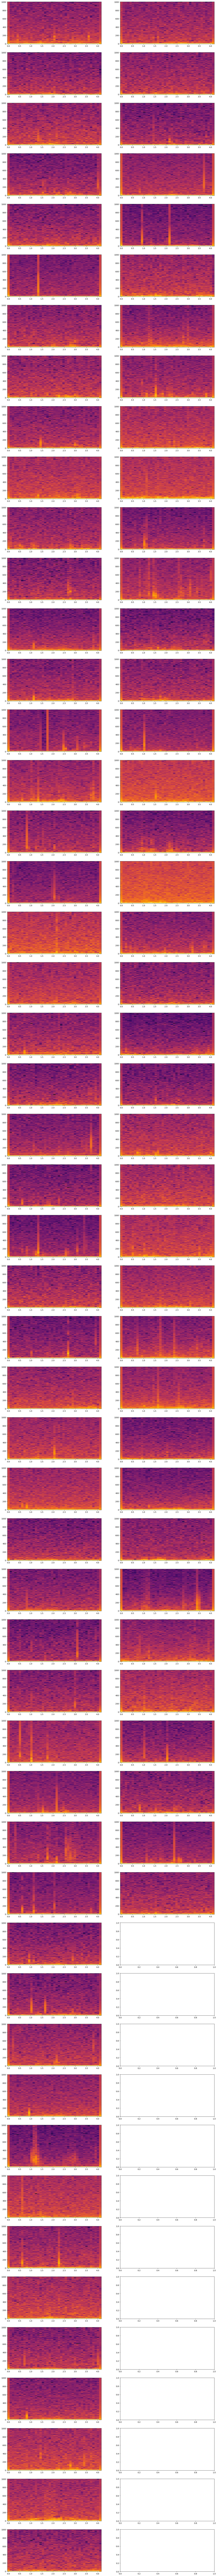

In [148]:
fig, ax = plt.subplots(len(stft_healthy),2, figsize=(20, 250))

for i, s in enumerate(stft_healthy):
    cax = ax[i][0].pcolormesh(s[1], s[0], s[2], shading='auto', cmap="inferno")
    #ax[i][0].colorbar(cax, ax=ax, label='Magnitude')

for i, s in enumerate(stft_pathology):
    cax = ax[i][1].pcolormesh(s[1], s[0], s[2], shading='auto', cmap="inferno")
